# Customer Segmentation: Clustering

### Libraries

In [85]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import missingno as msno

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

### Scikit-Learn libraries

In [122]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # Este no se para que es yet

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics


## Loading DATA

In [87]:
data = pd.read_csv('marketing_campaign.csv', sep='\t')
data.head(3)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0


In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

## Data cleaning

_Let's clean the dataset, check what's missing and do som feature engineering_

<AxesSubplot:>

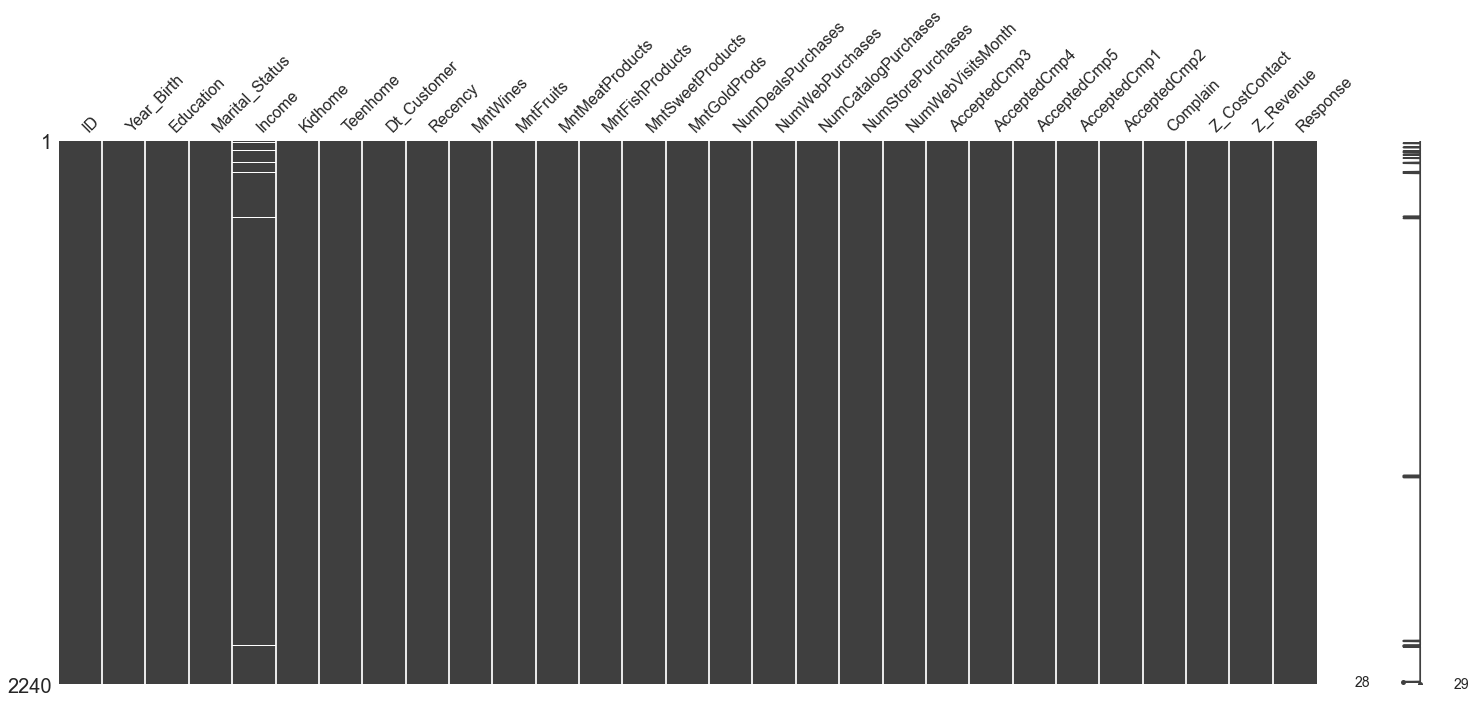

In [89]:
msno.matrix(data)

In [90]:
data.isna().sum().sort_values(ascending=False)[:6]

Income               24
ID                    0
NumDealsPurchases     0
Z_Revenue             0
Z_CostContact         0
Complain              0
dtype: int64

_As we can see, there are 24 missing values in 'Income' field, will just drop this values_

In [91]:
data.dropna(inplace=True)

_Lets correct the type of __Dt_Costumer__ and create a list with the values._

In [92]:
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'])
dates =[]
for i in data['Dt_Customer']:
    i=i.date()
    dates.append(i)

# Fechas del cliente más antiguo y el más reciente
print('The oldest client suscribed in:', min(dates))
print('The newest client suscribed in:', max(dates))

The oldest client suscribed in: 2012-01-08
The newest client suscribed in: 2014-12-06


_For simplicity and data integrity, will create a _feature_ called ___Costumer_for___ , which counts the days since client subscription till the latest subscription_

In [93]:
days = []

for i in dates:
    delta = max(dates) - i
    days.append(delta)

data['Customer_for'] = days
print(data['Customer_for'][:4])
data['Customer_for'] =pd.to_numeric(data['Customer_for'])
data['Customer_for'][:4]

0   971 days
1   125 days
2   472 days
3    65 days
Name: Customer_for, dtype: timedelta64[ns]


0    83894400000000000
1    10800000000000000
2    40780800000000000
3     5616000000000000
Name: Customer_for, dtype: int64

## ___Feature Engineering___

### Marital_Status

In [94]:
# Different values to this feature
data['Marital_Status'].value_counts()

Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

_To simplify this feature, will create a new _feature_ called __Living_with___

In [95]:
data['Living_with'] = data['Marital_Status'].replace({'Married':'Partner', 
                                                        'Together':'Partner',
                                                        'Single':'Alone',
                                                         'Divorced':'Alone',
                                                          'Widow':'Alone',
                                                          'Absurd':'Alone',
                                                          'YOLO':'Alone' })

In [96]:
data['Living_with'][:6]

0      Alone
1      Alone
2    Partner
3    Partner
4    Partner
5    Partner
Name: Living_with, dtype: object

### Education

In [97]:
# Different values to this feature
data.Education.value_counts()

Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64

_Will segment this in 3 groups, __undergraduated__, __graduated__ and __postgraduated___

In [98]:
data['Education'] = data.Education.replace({'Graduation':'Graduate',
                                             'PhD':'PostGraduate', 
                                             'Master':'PostGraduate',
                                             '2n Cycle': 'Undergraduate',
                                             'Basic':'Undergraduate'})

### Children

_Let's merge __kidhome__ and __teenhome__ in __Children___

In [99]:
data['Children']= data.Kidhome + data.Teenhome

### Age

In [100]:
data['Age'] = 2022 - data.Year_Birth
data['Age'][:4]

0    65
1    68
2    57
3    38
Name: Age, dtype: int64

### Spent

_This feature indicates the total spent in various categories for each costumer in the period of two years_ 

In [101]:
data['Spent'] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

### Family_Size

_This feature will indicate how many persons are living together_

In [102]:
data['Family_Size'] = data.Living_with.replace({'Alone':1, 'Partner':2})+data.Children
data['Family_Size'][:4]

0    1
1    3
2    2
3    3
Name: Family_Size, dtype: int64

### Is_Parent

In [103]:
data['Is_Parent'] = np.where(data.Children>0, 1, 0)
data.Is_Parent[:4]

0    0
1    1
2    0
3    1
Name: Is_Parent, dtype: int32

_For clarity, will rename this columns as it follows_

In [104]:
data=data.rename(columns={"MntWines": "Wines",
                        "MntFruits":"Fruits",
                        "MntMeatProducts":"Meat",
                        "MntFishProducts":"Fish",
                        "MntSweetProducts":"Sweets",
                        "MntGoldProds":"Gold"})

_And finally, lets drop what won't be needed_

In [105]:
drop = ['Marital_Status',  'Dt_Customer', 'Z_CostContact', 'Z_Revenue', 'Year_Birth', 'ID']
data.drop(drop, axis=1, inplace=True)

_Let's check some numerical values now_

In [106]:
data.select_dtypes(include=np.number).describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_for,Children,Age,Spent,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,4.423735e+16,0.947202,53.179603,607.075361,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,2.008532e+16,0.749062,11.985554,602.900476,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,26.000000,5.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,2.937600e+16,0.000000,45.000000,69.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,4.432320e+16,1.000000,52.000000,396.500000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,5.927040e+16,1.000000,63.000000,1048.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,9.184320e+16,3.000000,129.000000,2525.000000,5.000000,1.000000


_Lets pick some columns of interest and plot them, in searching for outliers_

Text(0.5, 1.0, 'PairPlot of Data Subset')

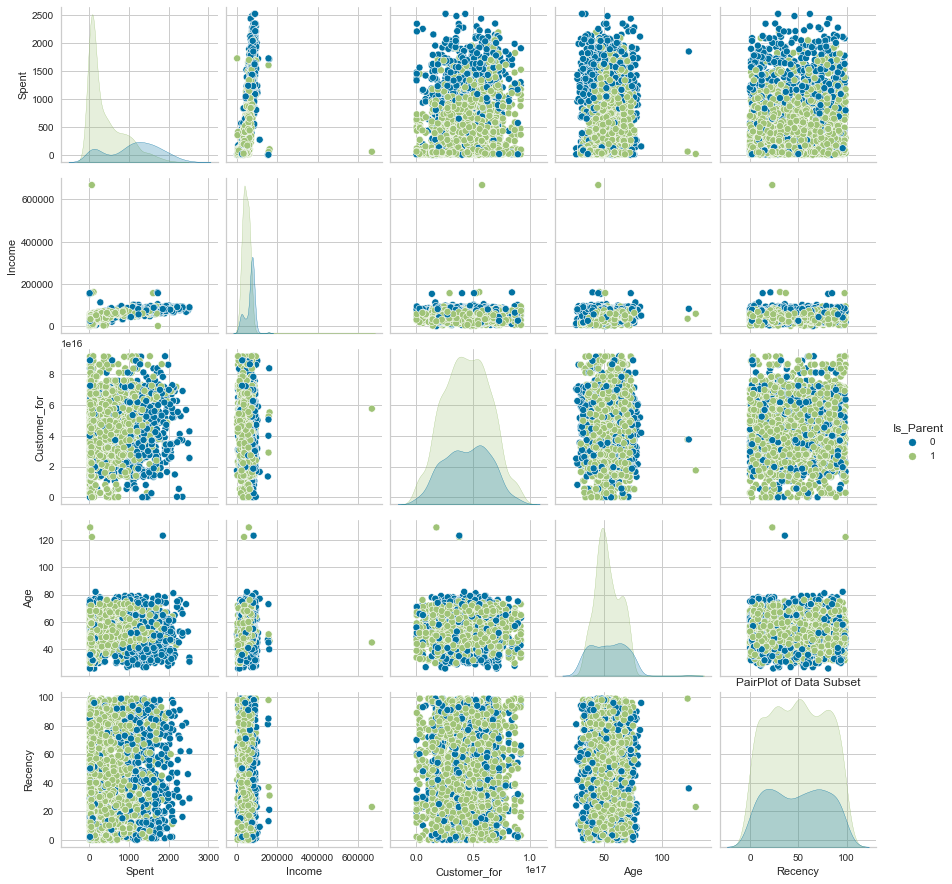

In [107]:
sns.pairplot(data[['Spent','Income','Customer_for','Age','Recency','Is_Parent']], hue='Is_Parent')
plt.title('PairPlot of Data Subset')

_As we can see, there are some outliers in fields: __Age__ and __Income__ . Lets drop them._

In [108]:
#Droping outliers
data = data[data['Age']<80]
data=data[data['Income']<200000]

                        Age vs Income


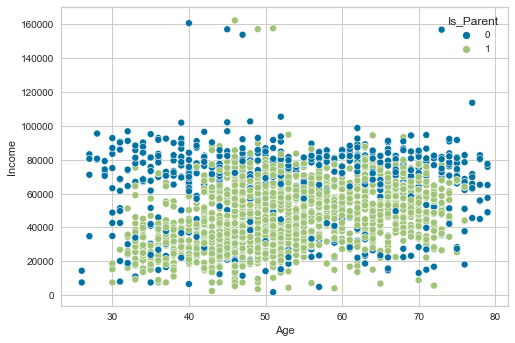

In [109]:
sns.scatterplot(x='Age', y='Income',hue='Is_Parent', data=data)
print('                        Age vs Income')


Text(0.5, 1.0, 'Correlation Map')

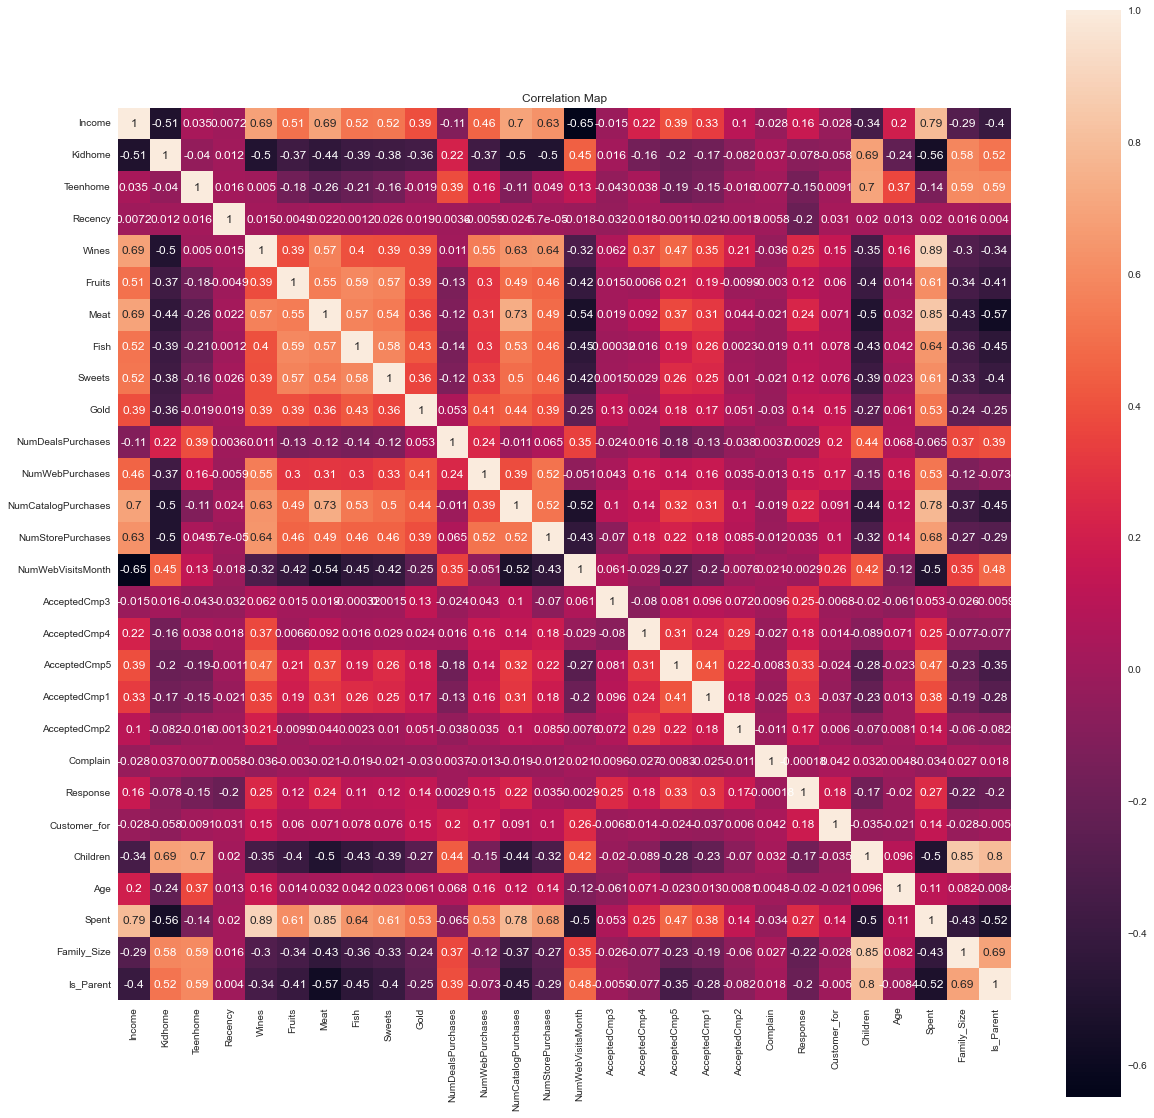

In [110]:
plt.figure(figsize=(20,20))
sns.heatmap(data.select_dtypes(include=np.number).corr(), annot=True, square=True)
plt.title('Correlation Map')

# Data Preprocessing

_In this section, will encode the categorical features with __LabelEncoder()__ and scale with __StandarScaler()__. Then i will apply some dimensionality reduction techniques_

### Categorical features

In [125]:
df_cat = data.select_dtypes(include='object')
df_cat.columns

Index(['Education', 'Living_with'], dtype='object')

In [128]:
lb_enc=LabelEncoder()
for i in df_cat.columns:
    print(i)
    data[i]= data[[i]].apply(lb_enc.fit_transform)
data

Education
Living_with


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,AcceptedCmp2,Complain,Response,Customer_for,Living_with,Children,Age,Spent,Family_Size,Is_Parent
0,0,58138.0,0,0,58,635,88,546,172,88,...,0,0,1,83894400000000000,0,0,65,1617,1,0
1,0,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,10800000000000000,0,2,68,27,3,1
2,0,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,40780800000000000,1,0,57,776,2,0
3,0,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,5616000000000000,1,1,38,53,3,1
4,1,58293.0,1,0,94,173,43,118,46,27,...,0,0,0,27734400000000000,1,1,41,422,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,0,61223.0,0,1,46,709,43,182,42,118,...,0,0,0,46742400000000000,1,1,55,1341,3,1
2236,1,64014.0,2,1,56,406,0,30,0,0,...,0,0,0,5270400000000000,1,3,76,444,5,1
2237,0,56981.0,0,0,91,908,48,217,32,12,...,0,0,0,27216000000000000,0,0,41,1241,1,0
2238,1,69245.0,0,1,8,428,30,214,80,30,...,0,0,0,27302400000000000,1,1,66,843,3,1


_All features are numerical now. Will proceed to create a copy_

In [ ]:
df = data.copy()

_Now will create a dataset, droping the columns on deals accepted and promotions._

In [130]:
df.columns

Index(['Education', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'Wines',
       'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'Customer_for',
       'Living_with', 'Children', 'Age', 'Spent', 'Family_Size', 'Is_Parent'],
      dtype='object')

In [134]:
df.drop(columns=['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response'], inplace=True)

### _StandarScaler()_

_Let scale our features, now that all are numerical_

In [135]:
scaler = StandardScaler()
scaler.fit(df)
scaled_df = pd.DataFrame(scaler.transform(df), columns=df.columns)
scaled_df

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_for,Living_with,Children,Age,Spent,Family_Size,Is_Parent
0,-0.892797,0.288058,-0.823378,-0.930483,0.311636,0.980238,1.551426,1.692805,2.452513,1.482737,...,2.507090,-0.555973,0.691484,1.972886,-1.349992,-1.266087,1.022823,1.678889,-1.760057,-1.583647
1,-0.892797,-0.260133,1.039125,0.907200,-0.379777,-0.872838,-0.637380,-0.718177,-0.650961,-0.634452,...,-0.571059,-1.171092,-0.133222,-1.664328,-1.349992,1.403810,1.279827,-0.963559,0.448133,0.631454
2,-0.892797,0.914383,-0.823378,-0.930483,-0.794624,0.359576,0.570237,-0.177939,1.338913,-0.147742,...,-0.229043,1.289385,-0.545575,-0.172468,0.740745,-1.266087,0.337478,0.281217,-0.655962,-1.583647
3,-0.892797,-1.175705,1.039125,-0.930483,-0.794624,-0.872838,-0.561904,-0.655670,-0.504915,-0.585781,...,-0.913076,-0.555973,0.279131,-1.922287,0.740745,0.068862,-1.290216,-0.920349,0.448133,0.631454
4,0.572000,0.295263,1.039125,-0.930483,1.556180,-0.391751,0.419285,-0.218122,0.152291,-0.001729,...,0.112974,0.059146,-0.133222,-0.821664,0.740745,0.068862,-1.033212,-0.307102,0.448133,0.631454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2205,-0.892797,0.431451,-0.823378,0.907200,-0.103211,1.199994,0.419285,0.067624,0.079268,2.212802,...,0.112974,-0.555973,-0.133222,0.124184,0.740745,0.068862,0.166142,1.220200,0.448133,0.631454
2206,0.572000,0.561178,2.901628,0.907200,0.242495,0.300183,-0.662539,-0.611023,-0.687473,-0.658787,...,-0.229043,-0.248414,0.691484,-1.939484,0.740745,2.738758,1.965172,-0.270540,2.656322,0.631454
2207,-0.892797,0.234280,-0.823378,-0.930483,1.452468,1.790959,0.545078,0.223892,-0.103289,-0.366761,...,0.112974,2.212063,0.279131,-0.847460,-1.349992,-1.266087,-1.033212,1.054008,-1.760057,-1.583647
2208,0.572000,0.804317,-0.823378,0.907200,-1.416896,0.365516,0.092222,0.210497,0.772986,0.071278,...,0.797007,1.289385,-0.957928,-0.843161,0.740745,0.068862,1.108491,0.392565,0.448133,0.631454


# Dimensionality Reduction

_Dimensionality reduction is the process of reducing the number of random variables under consideration, by obtaining a set of principal variables._

___PCA Principal Components Analysis___

In [138]:
pca = PCA(n_components=3)
pca.fit(scaled_df)
df_pc= pd.DataFrame(pca.transform(scaled_df), columns=[1,2,3])
df_pc.describe()

,1,2,3
count,2.210000e+03,2.210000e+03,2.210000e+03
mean,-7.073276e-17,1.286050e-17,1.768319e-17
std,2.878706e+00,1.707271e+00,1.222308e+00
min,-5.965662e+00,-4.312574e+00,-3.529037e+00
25%,-2.537369e+00,-1.332277e+00,-8.256353e-01
50%,-7.835730e-01,-1.602354e-01,-1.898281e-02
75%,2.380652e+00,1.241683e+00,8.010020e-01
max,7.449402e+00,6.144886e+00,6.610531e+00
